# Fashion-MNIST

For this project we are using the Fashion-MNIST dataset to predict the type of clothing. See https://github.com/zalandoresearch/fashion-mnist we will use the test set only once for each model, we will use cross validation for the tuning of the hyperparameters

In [2]:
import keras
from keras.datasets import fashion_mnist

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


In [3]:
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
           5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

## Visualization functions

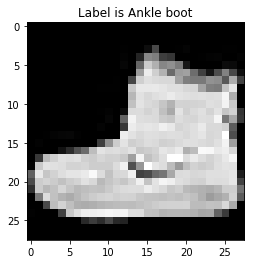

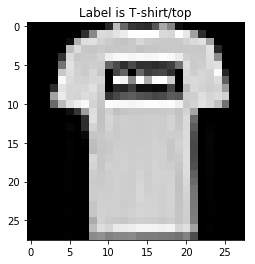

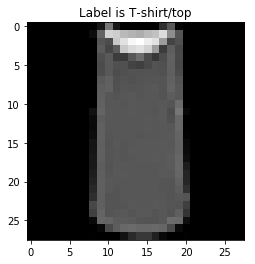

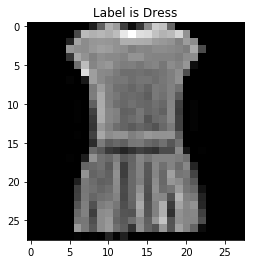

In [4]:
def plot_image(X, y=None):
    if y is None:
        y = 'unknown'
    else:
        y = classes[y]
    plt.title('Label is {label}'.format(label=y))
    plt.imshow(X, cmap='gray')
    plt.show()
    
plot_image(x_train[0], y_train[0])
plot_image(x_train[1], y_train[1])
plot_image(x_train[2], y_train[2])
plot_image(x_train[3], y_train[3])

## Preprocessing

For some of our methods we need to normalize our data, which we do on our training set and then apply on both our training and our test set. Since the images are grayscale we can just divide by 255 to map the values from 0 to 1.

In [21]:
x_train_prep = x_train / 255
x_test_prep = x_test / 255

x_train_prep_1d = x_train_prep.reshape(-1, 28 * 28)
x_test_prep_1d = x_test_prep.reshape(-1, 28 * 28)

x_train_prep_3d = x_train_prep.reshape(-1, 28, 28, 1)
x_test_prep_3d = x_test_prep.reshape(-1, 28, 28, 1)

# Models

First we will use some traditional machine learning models that do not take the structure of the image into account and then we will look at convolutional neural networks. We have also defined some functions to help us evaluate our models. Our models will be objects that have a `fit` and a `predict` method, the first for training and the second for prediction.

### Helper functions

In [37]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

In [81]:
import heapq

def find_example(model, x, y, true_class, predicted_class):
    y_true = y
    y_pred = model.predict(x)
    found_index = None
    for index, (current_y_true, current_y_pred) in enumerate(zip(y_true, y_pred)):
        if current_y_true == true_class and current_y_pred == predicted_class:
            found_index = index
            break
    return found_index

def plot_example(model, x, y, true_class, predicted_class, value=None):
    index = find_example(model, x, y, true_class, predicted_class)
    print('True class:', classes[true_class])
    print('Predicted class:', classes[predicted_class])
    if value is not None:
        print('Misclassified', value, 'times')
    if index is not None:
        plt.imshow(x_test_prep[index])
        plt.show()
    print('')
    
def analyze_model(model, x, y, inspect_n=10):
    y_pred = model.predict(x)
    conf_matrix = confusion_matrix(y, y_pred)
    print('Confusion matrix:')
    print(conf_matrix)
    print('')
    for _ in range(10):
        conf_matrix[_][_] = 0
    conf_matrix_flat = conf_matrix.reshape(-1, 1)
    biggest_indices = heapq.nlargest(inspect_n, range(len(conf_matrix_flat)), conf_matrix_flat.take)
    biggest_indices = np.unravel_index(biggest_indices, conf_matrix.shape)
    highest_values = conf_matrix[biggest_indices]
    for x_index, y_index, value in zip(biggest_indices[0], biggest_indices[1], highest_values):
        plot_example(model, x, y, x_index, y_index, value)

## Logistic regression

We want to try different values for the C regularization so we use GridSearchCV

In [39]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_param_grid = {'C': [0.001, 0.01, 0.1, 1., 10., 100.]}
lr_gridsearch = GridSearchCV(cv=4, estimator=logistic_regression, param_grid=logistic_param_grid, scoring='accuracy')
lr_gridsearch.fit(x_train_prep_1d, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [40]:
print(lr_gridsearch.best_params_)
print(lr_gridsearch.best_score_)

{'C': 0.1}
0.8563


Confusion matrix:
[[807   2  18  51   4   3 106   0   9   0]
 [  2 957   4  24   6   0   6   0   1   0]
 [ 19   3 734   9 131   1  93   0  10   0]
 [ 29  12  15 871  28   0  41   0   4   0]
 [  0   1 109  37 755   1  89   0   8   0]
 [  0   0   0   1   0 928   0  48   3  20]
 [130   2 120  39 102   1 581   0  25   0]
 [  0   0   0   0   0  33   0 935   0  32]
 [  6   1   5  11   4   5  22   5 941   0]
 [  0   0   0   0   0  14   0  44   1 941]]

True class: Pullover
Predicted class: Coat
Misclassified 131 times


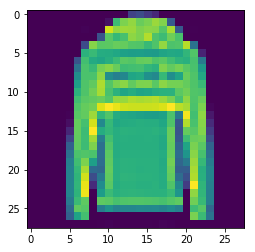


True class: Shirt
Predicted class: T-shirt/top
Misclassified 130 times


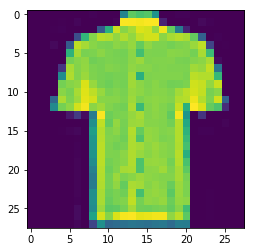


True class: Shirt
Predicted class: Pullover
Misclassified 120 times


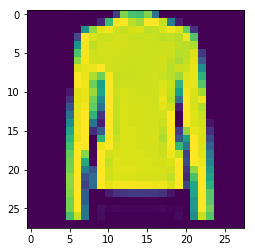


True class: Coat
Predicted class: Pullover
Misclassified 109 times


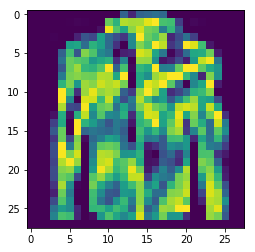


True class: T-shirt/top
Predicted class: Shirt
Misclassified 106 times


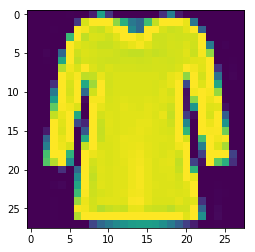


True class: Shirt
Predicted class: Coat
Misclassified 102 times


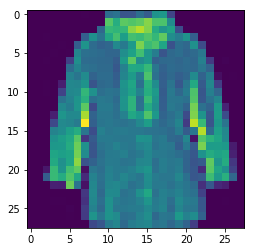


True class: Pullover
Predicted class: Shirt
Misclassified 93 times


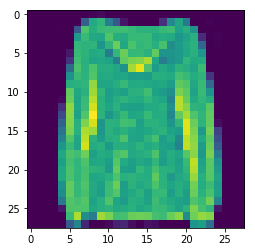


True class: Coat
Predicted class: Shirt
Misclassified 89 times


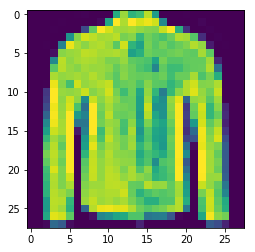


True class: T-shirt/top
Predicted class: Dress
Misclassified 51 times


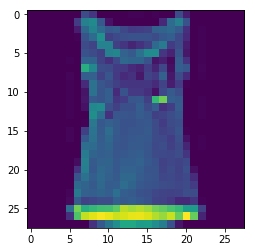


True class: Sandal
Predicted class: Sneaker
Misclassified 48 times


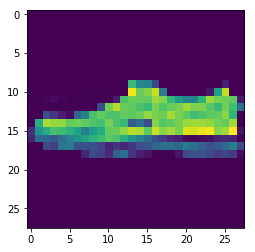

In [83]:
analyze_model(lr_gridsearch, x_test_prep_1d, y_test)

## Naive Bayes

We use Gaussian Naive Bayes because of the continuous features

In [85]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
print(np.mean(cross_val_score(estimator=naive_bayes, cv=4, scoring='accuracy', X=x_train_prep_1d, y=y_train)))
naive_bayes.fit(x_train_prep_1d, y_train)

0.590066666667


GaussianNB(priors=None)

Confusion matrix:
[[586  64  29 162 110   0  20   0  29   0]
 [  1 939  14  36   7   0   1   0   2   0]
 [  7  14 324  65 545   0  23   0  22   0]
 [  9 387   6 545  43   0   4   0   6   0]
 [  0  34  44 131 779   0   4   0   8   0]
 [  0   0   1   1   0 278   3 660   5  52]
 [117  34 112 200 435   0  40   0  62   0]
 [  0   0   0   0   0   3   0 988   0   9]
 [  0   2  19  85 149   3  27   4 710   1]
 [  0   0   1   1   0  16   3 304   8 667]]

True class: Sandal
Predicted class: Sneaker
Misclassified 660 times


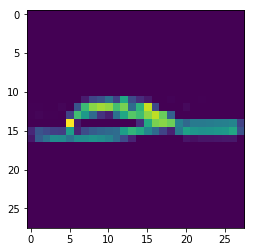


True class: Pullover
Predicted class: Coat
Misclassified 545 times


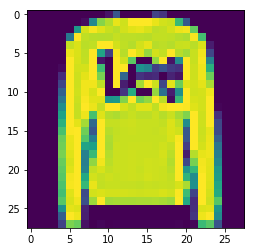


True class: Shirt
Predicted class: Coat
Misclassified 435 times


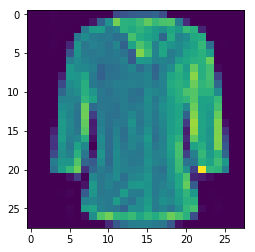


True class: Dress
Predicted class: Trouser
Misclassified 387 times


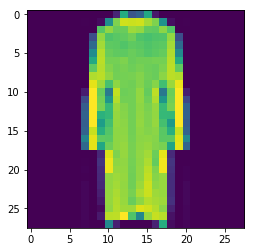


True class: Ankle boot
Predicted class: Sneaker
Misclassified 304 times


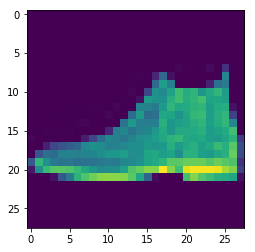


True class: Shirt
Predicted class: Dress
Misclassified 200 times


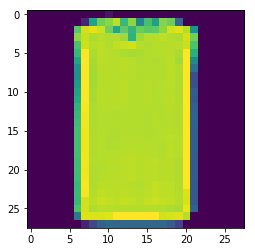


True class: T-shirt/top
Predicted class: Dress
Misclassified 162 times


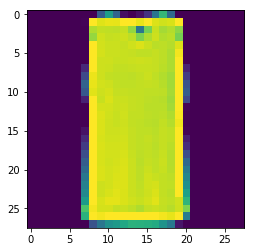


True class: Bag
Predicted class: Coat
Misclassified 149 times


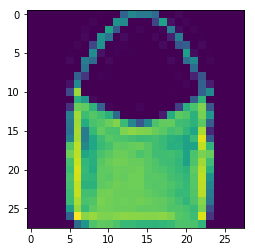


True class: Coat
Predicted class: Dress
Misclassified 131 times


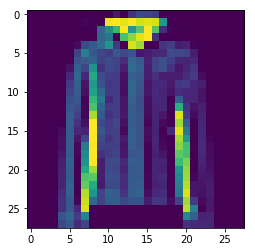


True class: Shirt
Predicted class: T-shirt/top
Misclassified 117 times


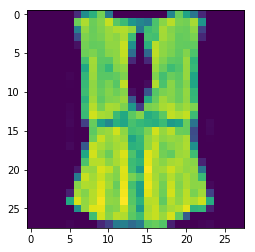

In [86]:
analyze_model(naive_bayes, x_test_prep_1d, y_test)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
rf_param_grid = {'max_depth': [3, 5, 7, 9], 
                 'max_features': ['auto', 'log2', 0.15, None]}
rf_gridsearch = GridSearchCV(cv=4, estimator=random_forest, param_grid=rf_param_grid, scoring='accuracy', n_jobs=1)
rf_gridsearch.fit(x_train_prep_1d, y_train)

In [ ]:
print(rf_gridsearch.best_params_)
print(rf_gridsearch.best_score_)

In [ ]:
analyze_model(rf_gridsearch, x_test_prep_1d, y_test)

## Convolutional neural network

Convolutional neural networks are a specific type of neural networks that use the spatial structure of your data. They are used a lot in computer vision problem but also on text and time series. http://colah.github.io/posts/2014-07-Understanding-Convolutions/

In [97]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import sparse_categorical_accuracy, sparse_categorical_crossentropy

In [103]:
class ConvModel:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        
    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)  

## Convolutional model without dropout or pooling, 3 conv layers and 2 dense layers

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Conv2D(16, (3, 3), activation='sigmoid'))
model.add(Conv2D(8, (3, 3), activation='sigmoid'))
model.add(Flatten())
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_3c_2d = ConvModel(model)
conv_model_3c_2d.fit(x_train_prep_3d, y_train, batch_size=32, epochs=20, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 272us/step - loss: 2.2354 - sparse_categorical_accuracy: 0.1327 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.7029
Epoch 2/20
60000/60000 [==============================] - 16s 262us/step - loss: 0.6007 - sparse_categorical_accuracy: 0.7863 - val_loss: 0.5335 - val_sparse_categorical_accuracy: 0.8037
Epoch 3/20
60000/60000 [==============================] - 15s 252us/step - loss: 0.4643 - sparse_categorical_accuracy: 0.8324 - val_loss: 0.4653 - val_sparse_categorical_accuracy: 0.8322
Epoch 4/20
60000/60000 [==============================] - 15s 251us/step - loss: 0.4248 - sparse_categorical_accuracy: 0.8463 - val_loss: 0.4427 - val_sparse_categorical_accuracy: 0.8438
Epoch 5/20
60000/60000 [==============================] - 15s 255us/step - loss: 0.3968 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.4204 - val_sparse_categorical_accuracy: 0.8472
Epoch 6/20
6000

## Convolutional model without dropout or pooling, 2 conv layers and 1 dense layers

In [105]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Conv2D(8, (3, 3), activation='sigmoid'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_2c_1d = ConvModel(model)
conv_model_2c_1d.fit(x_train_prep_3d, y_train, batch_size=32, epochs=5, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 219us/step - loss: 0.7851 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.5063 - val_sparse_categorical_accuracy: 0.8157
Epoch 2/5
60000/60000 [==============================] - 14s 237us/step - loss: 0.4436 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.4454 - val_sparse_categorical_accuracy: 0.8368
Epoch 3/5
60000/60000 [==============================] - 13s 221us/step - loss: 0.3869 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.3993 - val_sparse_categorical_accuracy: 0.8603
Epoch 4/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.3612 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.3875 - val_sparse_categorical_accuracy: 0.8639
Epoch 5/5
60000/60000 [==============================] - 14s 228us/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8758 - val_loss: 0.3848 - val_sparse_categorical_accuracy: 0.8628


Confusion matrix:
[[870   5  38  33   3   1  39   0  11   0]
 [  2 976   2  16   2   0   1   0   1   0]
 [ 12   2 893   9  51   0  31   0   2   0]
 [ 34  13  25 892  18   0  15   0   3   0]
 [  1   3 172  45 728   1  47   0   3   0]
 [  0   0   0   1   0 949   0  32   1  17]
 [221   3 186  39  85   0 453   0  12   1]
 [  0   0   0   0   0   5   0 948   0  47]
 [  3   2  13   3   2   2  11   7 955   2]
 [  0   0   0   0   0   6   0  29   1 964]]

True class: Shirt
Predicted class: T-shirt/top
Misclassified 221 times


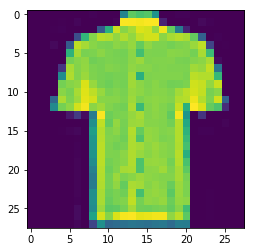


True class: Shirt
Predicted class: Pullover
Misclassified 186 times


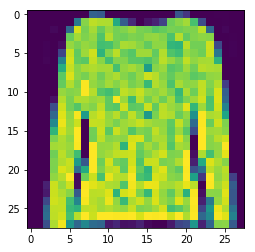


True class: Coat
Predicted class: Pullover
Misclassified 172 times


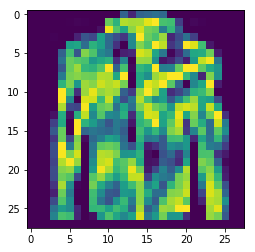


True class: Shirt
Predicted class: Coat
Misclassified 85 times


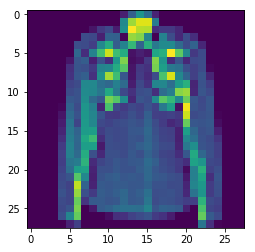


True class: Pullover
Predicted class: Coat
Misclassified 51 times


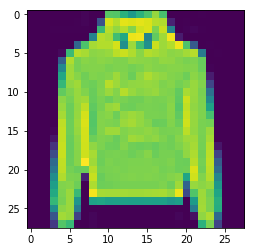


True class: Coat
Predicted class: Shirt
Misclassified 47 times


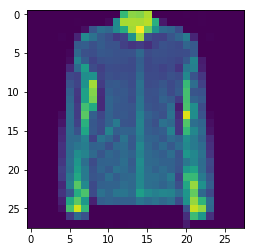


True class: Sneaker
Predicted class: Ankle boot
Misclassified 47 times


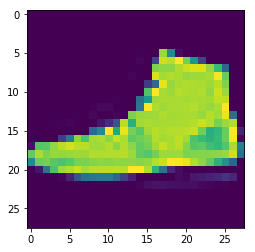


True class: Coat
Predicted class: Dress
Misclassified 45 times


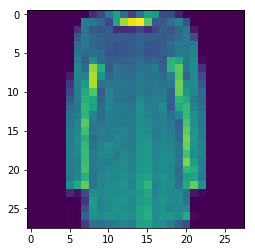


True class: T-shirt/top
Predicted class: Shirt
Misclassified 39 times


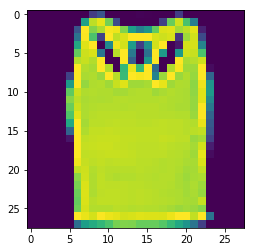


True class: Shirt
Predicted class: Dress
Misclassified 39 times


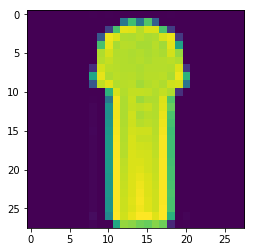

In [108]:
analyze_model(conv_model_2c_1d, x_test_prep_3d, y_test)

## Convolutional model pooling, 3 conv layers and 2 dense layers, 0.1 dropout

In [114]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Conv2D(16, (3, 3), activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_3c_2d_do10 = ConvModel(model)
conv_model_3c_2d_do10.fit(x_train_prep_3d, y_train, batch_size=32, epochs=40, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 20s 327us/step - loss: 1.4674 - sparse_categorical_accuracy: 0.4634 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.7649
Epoch 2/40
60000/60000 [==============================] - 19s 312us/step - loss: 0.5851 - sparse_categorical_accuracy: 0.7851 - val_loss: 0.5622 - val_sparse_categorical_accuracy: 0.7818
Epoch 3/40
60000/60000 [==============================] - 18s 294us/step - loss: 0.5129 - sparse_categorical_accuracy: 0.8125 - val_loss: 0.5131 - val_sparse_categorical_accuracy: 0.8173
Epoch 4/40
60000/60000 [==============================] - 17s 291us/step - loss: 0.4652 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.4632 - val_sparse_categorical_accuracy: 0.8361
Epoch 5/40
60000/60000 [==============================] - 18s 292us/step - loss: 0.4301 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.4513 - val_sparse_categorical_accuracy: 0.8400
Epoch 6/40
6000

Confusion matrix:
[[836   2  24  28   5   2  93   0  10   0]
 [  5 970   1  17   2   0   2   1   2   0]
 [ 13   2 865   9  66   0  43   0   2   0]
 [ 14   3  17 916  29   0  18   0   3   0]
 [  1   2  74  33 846   0  40   0   4   0]
 [  1   0   0   1   0 976   0  10   1  11]
 [114   1  98  25 112   0 639   0  11   0]
 [  0   0   0   0   0  15   0 964   0  21]
 [  4   0   5   3   4   2   2   4 974   2]
 [  1   0   0   0   0   9   0  32   1 957]]

True class: Shirt
Predicted class: T-shirt/top
Misclassified 114 times


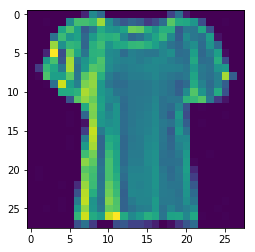


True class: Shirt
Predicted class: Coat
Misclassified 112 times


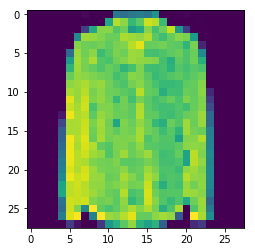


True class: Shirt
Predicted class: Pullover
Misclassified 98 times


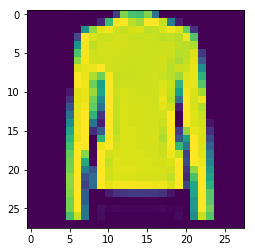


True class: T-shirt/top
Predicted class: Shirt
Misclassified 93 times


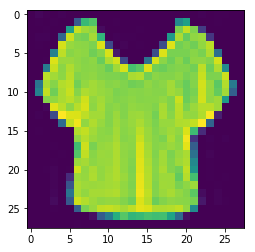


True class: Coat
Predicted class: Pullover
Misclassified 74 times


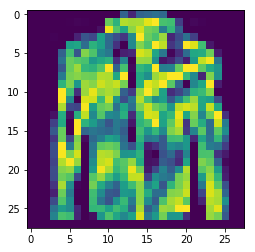


True class: Pullover
Predicted class: Coat
Misclassified 66 times


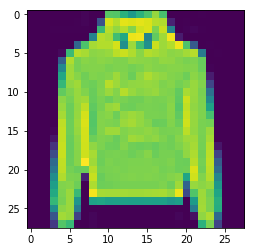


True class: Pullover
Predicted class: Shirt
Misclassified 43 times


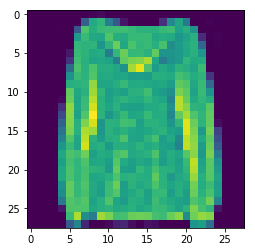


True class: Coat
Predicted class: Shirt
Misclassified 40 times


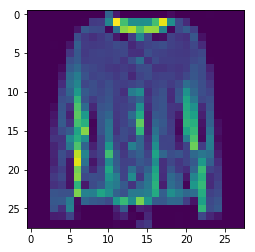


True class: Coat
Predicted class: Dress
Misclassified 33 times


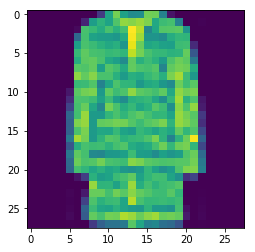


True class: Ankle boot
Predicted class: Sneaker
Misclassified 32 times


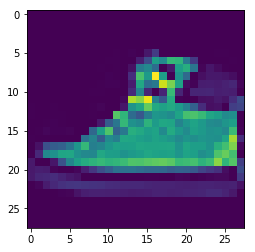

In [115]:
analyze_model(conv_model_3c_2d_do10, x_test_prep_3d, y_test)

## Convolutional model pooling, 5 conv layers and 2 dense layers, 0.1 dropout

In [112]:
model_6c_2d_2p_do10 = Sequential()
model_6c_2d_2p_do10.add(Conv2D(64, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(64, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model_6c_2d_2p_do10.add(MaxPooling2D(pool_size=(2, 2)))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_6c_2d_2p_do10.add(MaxPooling2D(pool_size=(2, 2)))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_6c_2d_2p_do10.add(Flatten())
model_6c_2d_2p_do10.add(Dense(64, activation='sigmoid'))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Dense(10, activation='softmax'))

optimizer = Adam()
model_6c_2d_2p_do10.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_6c_2d_2p_do10 = ConvModel(model_6c_2d_2p_do10)
conv_model_6c_2d_2p_do10.fit(x_train_prep_3d, y_train, batch_size=32, epochs=40, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 23s 384us/step - loss: 1.2268 - sparse_categorical_accuracy: 0.5315 - val_loss: 0.5937 - val_sparse_categorical_accuracy: 0.7713
Epoch 2/40
60000/60000 [==============================] - 22s 369us/step - loss: 0.5136 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.4825 - val_sparse_categorical_accuracy: 0.8140
Epoch 3/40
60000/60000 [==============================] - 23s 377us/step - loss: 0.4413 - sparse_categorical_accuracy: 0.8353 - val_loss: 0.4116 - val_sparse_categorical_accuracy: 0.8443
Epoch 4/40
60000/60000 [==============================] - 23s 379us/step - loss: 0.4015 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.3827 - val_sparse_categorical_accuracy: 0.8589
Epoch 5/40
60000/60000 [==============================] - 22s 366us/step - loss: 0.3701 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.3670 - val_sparse_categorical_accuracy: 0.8648
Epoch 6/40
6000

Confusion matrix:
[[876   0  10  15   3   0  82   0  14   0]
 [  4 982   0  10   2   0   1   0   1   0]
 [ 20   0 894  12  31   0  43   0   0   0]
 [ 18   6  11 917  22   0  24   0   2   0]
 [  2   2  58  43 836   0  58   0   1   0]
 [  0   0   0   0   0 986   1  12   0   1]
 [131   0  72  21  65   0 701   0  10   0]
 [  0   0   0   0   0  10   0 975   1  14]
 [  3   1   3   2   0   1   0   1 989   0]
 [  0   0   0   0   0   7   0  42   1 950]]

True class: Shirt
Predicted class: T-shirt/top
Misclassified 131 times


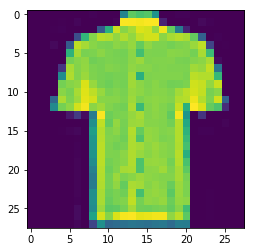


True class: T-shirt/top
Predicted class: Shirt
Misclassified 82 times


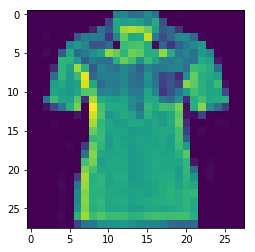


True class: Shirt
Predicted class: Pullover
Misclassified 72 times


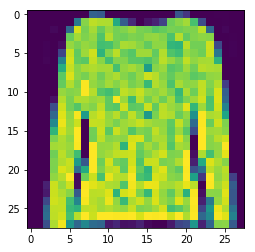


True class: Shirt
Predicted class: Coat
Misclassified 65 times


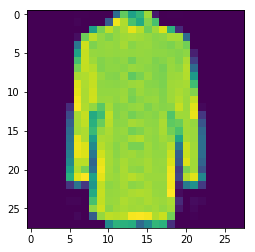


True class: Coat
Predicted class: Pullover
Misclassified 58 times


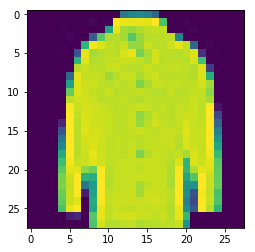


True class: Coat
Predicted class: Shirt
Misclassified 58 times


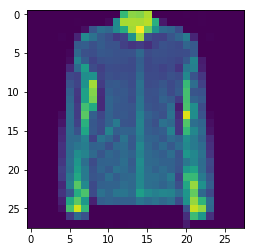


True class: Pullover
Predicted class: Shirt
Misclassified 43 times


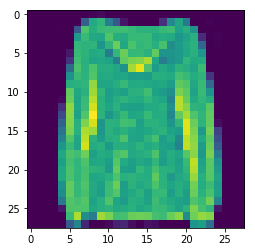


True class: Coat
Predicted class: Dress
Misclassified 43 times


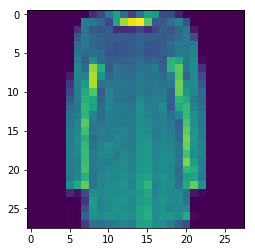


True class: Ankle boot
Predicted class: Sneaker
Misclassified 42 times


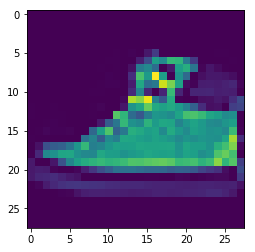


True class: Pullover
Predicted class: Coat
Misclassified 31 times


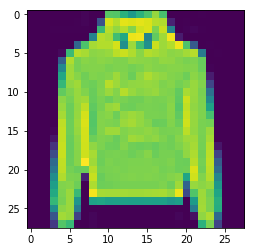

In [113]:
analyze_model(conv_model_6c_2d_2p_do10, x_test_prep_3d, y_test)